In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient
from finvizfinance.screener.overview import Overview
import alpaca_trade_api as tradeapi
import datetime

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import pandas_datareader as pdr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

warnings.filterwarnings('ignore')

In [2]:
# Read your api key environment variable
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("news_api")
print(api_key)

72eb697da30247e48848efe5e7881618


In [3]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=os.environ["news_api"])

In [4]:
foverview = Overview()

filters_dict = {
    'Performance':'Today Up',
    'Price':"Under $2", 
    'Relative Volume': "Over 5"
}
foverview.set_filter(filters_dict=filters_dict)

tickers = foverview.ScreenerView()
#tickers.sort_values(by='Volume', inplace=True, ascending=False)
tickers.set_index('Ticker', inplace=True )
tickers.head(8)

,Company,Sector,Industry,Country,Market Cap,P/E,Price,Change,Volume
Ticker,,,,,,,,,
CTXR,"Citius Pharmaceuticals, Inc.",Healthcare,Biotechnology,USA,120040000.0,None,1.69,0.2426,31928991.0
CYRN,CYREN Ltd.,Technology,Software - Infrastructure,USA,80940000.0,None,1.34,0.0806,7206560.0
DFFN,Diffusion Pharmaceuticals Inc.,Healthcare,Biotechnology,USA,117620000.0,None,1.70,0.3710,106592258.0
DNN,Denison Mines Corp.,Energy,Uranium,Canada,923800000.0,None,1.49,0.3423,210874452.0
GSV,Gold Standard Ventures Corp,Basic Materials,Gold,Canada,279360000.0,None,0.89,0.0490,32033975.0
ITP,"IT Tech Packaging, Inc.",Basic Materials,Paper & Paper Products,China,42540000.0,None,1.44,0.3211,41753643.0
PVL,Permianville Royalty Trust,Energy,Oil & Gas E&P,USA,49640000.0,6.98,1.57,0.1056,1983265.0
SONM,"Sonim Technologies, Inc.",Technology,Communication Equipment,USA,104040000.0,None,1.56,0.3220,15921466.0


In [5]:
def get_sentiment(company):
    stock_headlines = ( newsapi.get_everything(
    q=company,
    language='en',
    sort_by='relevancy'))

    sentiments = []

    for articles in stock_headlines['articles']:
        try:
            text = articles['content']
            results = analyzer.polarity_scores(text)
            compound = results['compound']
            pos = results['pos']
            neu = results['neu']
            neg = results['neg'] 

            #put data into sentiments
            sentiments.append({
                'text':text,
                'Compound':compound,
                'Positive':pos,
                'Negative':neg,
                'Neutral':neu})

        except AttributeError:
            pass
    fininal_sentiments = pd.DataFrame(sentiments)
    if not fininal_sentiments.empty:
        return(fininal_sentiments["Positive"].mean())
    else:
        return(0)

In [6]:
ticker_sentiment = [] 
for ticker in tickers.index: 
    sentiment = get_sentiment(tickers['Company'][ticker])
    print(sentiment)
    if float(sentiment) >= 0.05:
        ticker_sentiment.append(ticker)
        print(f"{ticker} does meets our sentiment requirement")
    else:
        print(f"{ticker} does not meet our sentiment requirement")

0.06075
CTXR does meets our sentiment requirement
0.055125
CYRN does meets our sentiment requirement
0.034846153846153846
DFFN does not meet our sentiment requirement
0.09937499999999999
DNN does meets our sentiment requirement
0.0374
GSV does not meet our sentiment requirement
0.04215
ITP does not meet our sentiment requirement
0
PVL does not meet our sentiment requirement
0.0
SONM does not meet our sentiment requirement


In [7]:
### Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [8]:
#Set time frame for reporting stocks
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days = 2) 
start_time = tomorrow.strftime("%b %d %Y") + " 10:00AM"
next_day = today + datetime.timedelta(days = 1) 
end_time = next_day.strftime("%b %d %Y") + " 1:00PM"

date_from = datetime.datetime.strptime(
    start_time, '%b %d %Y %I:%M%p')
date_to = datetime.datetime.strptime(
    end_time, '%b %d %Y %I:%M%p')

In [9]:
# Set timeframe to '1D'
timeframe = "1D"

#Set timeframe for last 2 years
start_date = pd.Timestamp("2018-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp(next_day, tz="America/New_York").isoformat()

#Get ticker data
df_ticker = api.get_barset(
    ticker_sentiment,
    timeframe,
    start=start_date,
    end=end_date
).df

df_ticker.dropna(inplace=True)
df_ticker.tail()

CTXR                                CYRN        \
                           open  high   low   close    volume  open  high   
time                                                                        
2021-02-09 00:00:00-05:00  1.39  1.43  1.34  1.4100   4682026  1.51  1.60   
2021-02-10 00:00:00-05:00  1.43  1.50  1.25  1.3900   5743961  1.52  1.52   
2021-02-11 00:00:00-05:00  1.40  1.43  1.32  1.3600   2728313  1.25  1.28   
2021-02-12 00:00:00-05:00  1.37  1.39  1.30  1.3600   7655357  1.24  1.28   
2021-02-16 00:00:00-05:00  1.39  1.78  1.37  1.6801  32160117  1.26  1.35   

                                                     DNN                \
                            low   close   volume    open  high     low   
time                                                                     
2021-02-09 00:00:00-05:00  1.40  1.4789  3210934  0.9459  0.95  0.8953   
2021-02-10 00:00:00-05:00  1.26  1.3900  2021896  1.0400  1.04  0.9000   
2021-02-11 00:00:00-05:00  1.15  1.2300  7352567  0.9713  1.27  0.9524   
2021-02-12 00:00:00-05:00  1.18  1.2350  6925753  1.3300  1.34  1.0700   
2021-02-16 00:00:00-05:00  1.26  1.3400  6785827  1.2800  1.55  1.2400   

                                              
                            close     volume  
time                                          
2021-02-09 00:00:00-05:00  0.9255   12544068  
2021-02-10 00:00:00-05:00  0.9872   18898232  
2021-02-11 00:00:00-05:00  1.0400  131220760  
2021-02-12 00:00:00-05:00  1.1100  132257543  
2021-02-16 00:00:00-05:00  1.4600  190110431

In [10]:
#df_ticker=df_ticker.loc[:, (slice(None), ['volume','close'])]
#df_ticker.head()

In [11]:
df_ticker.columns = ['_'.join(col) for col in df_ticker.columns]
df_ticker.head()

,CTXR_open,CTXR_high,CTXR_low,CTXR_close,CTXR_volume,CYRN_open,CYRN_high,CYRN_low,CYRN_close,CYRN_volume,DNN_open,DNN_high,DNN_low,DNN_close,DNN_volume
time,,,,,,,,,,,,,,,
2020-09-23 00:00:00-04:00,1.0500,1.0500,1.0000,1.0200,468543,0.9300,0.9500,0.8700,0.9301,121350,0.4230,0.4230,0.3812,0.4195,1340210
2020-09-24 00:00:00-04:00,0.9983,1.0099,0.9600,0.9692,394483,0.9050,1.0400,0.9050,1.0393,57062,0.4200,0.4200,0.3971,0.4113,1205492
2020-09-25 00:00:00-04:00,0.9693,1.0100,0.9693,1.0100,208399,1.0100,1.0500,0.9750,1.0473,30388,0.4110,0.4192,0.3952,0.4184,789729
2020-09-28 00:00:00-04:00,1.0000,1.0800,1.0000,1.0550,695493,1.0900,1.1000,0.9900,1.0324,14040,0.4200,0.4344,0.4068,0.4270,1218578
2020-09-29 00:00:00-04:00,1.0500,1.1000,0.9800,1.0450,2017525,1.0381,1.0899,0.9901,1.0440,31325,0.4236,0.4270,0.4080,0.4100,1302368


<AxesSubplot:xlabel='time'>

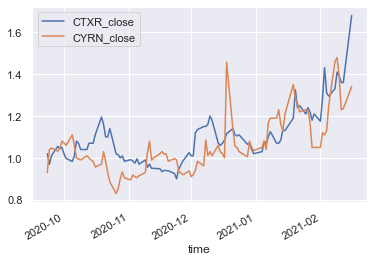

In [12]:
#df_ticker.iloc[:, [0,2]].plot()
df_ticker.iloc[:, [3,8]].plot()

In [13]:
df_ticker_1=df_ticker.iloc[:, [0,1,2,3,4]]
df_ticker_1.head()

,CTXR_open,CTXR_high,CTXR_low,CTXR_close,CTXR_volume
time,,,,,
2020-09-23 00:00:00-04:00,1.0500,1.0500,1.0000,1.0200,468543
2020-09-24 00:00:00-04:00,0.9983,1.0099,0.9600,0.9692,394483
2020-09-25 00:00:00-04:00,0.9693,1.0100,0.9693,1.0100,208399
2020-09-28 00:00:00-04:00,1.0000,1.0800,1.0000,1.0550,695493
2020-09-29 00:00:00-04:00,1.0500,1.1000,0.9800,1.0450,2017525


In [14]:
import re
delimiters = '_'
matchPattern = ''.join(map(re.escape, delimiters))
df_ticker_1.columns = [re.split(matchPattern, i)[1] for i in df_ticker_1.columns ]
df_ticker_1.head()

,open,high,low,close,volume
time,,,,,
2020-09-23 00:00:00-04:00,1.0500,1.0500,1.0000,1.0200,468543
2020-09-24 00:00:00-04:00,0.9983,1.0099,0.9600,0.9692,394483
2020-09-25 00:00:00-04:00,0.9693,1.0100,0.9693,1.0100,208399
2020-09-28 00:00:00-04:00,1.0000,1.0800,1.0000,1.0550,695493
2020-09-29 00:00:00-04:00,1.0500,1.1000,0.9800,1.0450,2017525


<AxesSubplot:title={'center':'Returns'}, xlabel='time'>

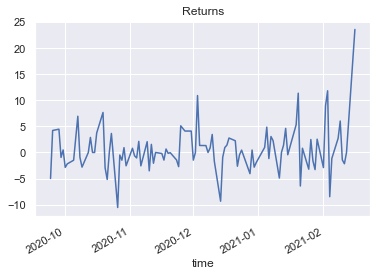

In [15]:
returns_1 = df_ticker_1.iloc[:, [3]].pct_change() * 100
returns_1.plot(title="Returns",legend=False)

In [16]:
df_ticker_1['returns'] = returns_1.copy()
df_ticker_1 = df_ticker_1.dropna()
df_ticker_1.head()

,open,high,low,close,volume,returns
time,,,,,,
2020-09-24 00:00:00-04:00,0.9983,1.0099,0.9600,0.9692,394483,-4.980392
2020-09-25 00:00:00-04:00,0.9693,1.0100,0.9693,1.0100,208399,4.209657
2020-09-28 00:00:00-04:00,1.0000,1.0800,1.0000,1.0550,695493,4.455446
2020-09-29 00:00:00-04:00,1.0500,1.1000,0.9800,1.0450,2017525,-0.947867
2020-09-30 00:00:00-04:00,1.0900,1.0900,1.0300,1.0500,1051045,0.478469


In [17]:
# forming classes for classification: -1 for losing day. +1 for winning day
df_ticker_1['target'] = np.where(df_ticker_1.returns.shift(-1) > 0, 1, -1)
df_ticker_1.head()

,open,high,low,close,volume,returns,target
time,,,,,,,
2020-09-24 00:00:00-04:00,0.9983,1.0099,0.9600,0.9692,394483,-4.980392,1
2020-09-25 00:00:00-04:00,0.9693,1.0100,0.9693,1.0100,208399,4.209657,1
2020-09-28 00:00:00-04:00,1.0000,1.0800,1.0000,1.0550,695493,4.455446,-1
2020-09-29 00:00:00-04:00,1.0500,1.1000,0.9800,1.0450,2017525,-0.947867,1
2020-09-30 00:00:00-04:00,1.0900,1.0900,1.0300,1.0500,1051045,0.478469,-1


In [18]:
# count target values
df_ticker_1['target'].value_counts()

-1    54
 1    45
Name: target, dtype: int64

In [19]:
features = ['volume','returns']
labels = 'target'

<AxesSubplot:xlabel='returns', ylabel='volume'>

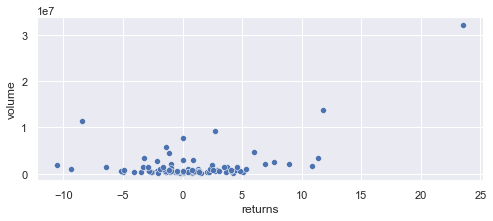

In [20]:
# scatter plot for volume and returns
plt.figure(figsize=(8,3))
sns.scatterplot(x=df_ticker_1['returns'],y=df_ticker_1['volume'])

# Feature Extraction

In [21]:
# features
features_list = []

# Standard deviation calculation
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    df_ticker_1[col_name] = df_ticker_1['close'].rolling(window=i).std()
    features_list.append(col_name)
    
# Mean calculation
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    df_ticker_1[col_name] = df_ticker_1['close'].rolling(window=i).mean()
    features_list.append(col_name)
    
# % change calculation
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    df_ticker_1[col_name] = df_ticker_1['close'].pct_change().rolling(window=i).sum()
    features_list.append(col_name)
    
# volume mean calculation
col_name = 'vma_4'
df_ticker_1[col_name] = df_ticker_1['volume'].rolling(4).mean()
features_list.append(col_name)

# intraday calculation
col_name = 'co'
df_ticker_1[col_name] = df_ticker_1['close'] - df_ticker_1['open']
features_list.append(col_name)

features_list

['std_5',
 'std_10',
 'std_15',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_25',
 'pct_3',
 'pct_6',
 'pct_9',
 'vma_4',
 'co']

In [22]:
# Remove Nans
df_ticker_1.dropna(inplace=True)

#taking a peek at features
df_ticker_1[features_list+['target']].head()

,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co,target
time,,,,,,,,,,,,,
2020-10-28 00:00:00-04:00,0.061441,0.065001,0.055249,1.09099,1.079993,1.064535,1.056796,-0.124943,-0.140222,-0.055635,723453.0,-0.0100,1
2020-10-29 00:00:00-04:00,0.058146,0.069846,0.058187,1.08491,1.075940,1.063995,1.058396,-0.010480,-0.079380,-0.083818,721767.5,0.0092,-1
2020-10-30 00:00:00-04:00,0.014391,0.075982,0.062358,1.07226,1.072173,1.063280,1.057336,-0.031044,-0.104846,-0.185860,334639.5,0.0135,1
2020-11-02 00:00:00-05:00,0.012803,0.066070,0.065341,1.05190,1.068933,1.063700,1.054792,-0.008233,-0.133177,-0.148455,330652.0,0.0014,-1
2020-11-03 00:00:00-05:00,0.010760,0.056794,0.068826,1.03442,1.063273,1.062455,1.052396,-0.023788,-0.034268,-0.103168,287745.5,-0.0249,-1


# Create Train_test split

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(df_ticker_1[features_list].iloc[:-1],
                                                   df_ticker_1.iloc[:-1]['target'],
                                                   test_size = 0.2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape 

((59, 12), (59,), (15, 12), (15,))

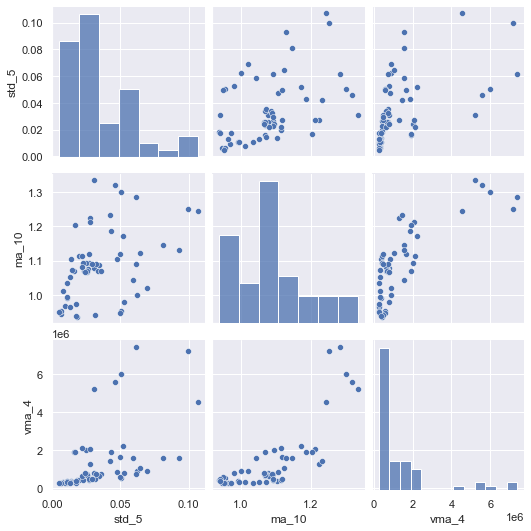

In [24]:
sns.pairplot(X_train[['std_5','ma_10','vma_4']])

In [25]:
# scale features
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

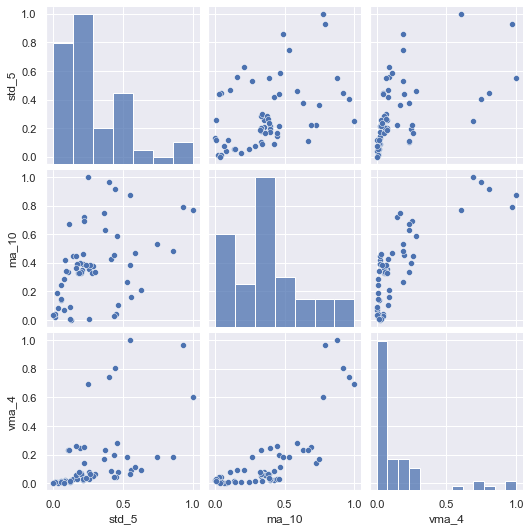

In [26]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
sns.pairplot(X_train_scaled_df[['std_5','ma_10','vma_4']])

In [27]:
X_train_scaled_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
std_5,59.0,0.29,0.23,0.0,0.12,0.22,0.44,1.0
std_10,59.0,0.46,0.31,0.0,0.24,0.39,0.77,1.0
std_15,59.0,0.43,0.30,0.0,0.15,0.40,0.70,1.0
ma_10,59.0,0.37,0.26,0.0,0.17,0.36,0.46,1.0
ma_15,59.0,0.38,0.26,0.0,0.19,0.37,0.49,1.0
ma_20,59.0,0.36,0.25,0.0,0.17,0.38,0.46,1.0
ma_25,59.0,0.37,0.25,0.0,0.18,0.35,0.48,1.0
pct_3,59.0,0.47,0.22,0.0,0.33,0.43,0.62,1.0
pct_6,59.0,0.46,0.24,0.0,0.28,0.46,0.60,1.0
pct_9,59.0,0.51,0.24,0.0,0.33,0.45,0.72,1.0


# Logistic Regression

In [28]:
# create model
model_1 = LogisticRegression()

# train model
model_1.fit(X_train_scaled, Y_train)

LogisticRegression()

In [29]:
# make some predictions
Y_pred_train_1 = model_1.predict(X_train_scaled)

Y_pred_1 = model_1.predict(X_test_scaled)

In [30]:
# accuracy
print("Logistic Regression Model train accuracy:", accuracy_score(Y_train, Y_pred_train_1))
print("Logistic Regression Model test accuracy:", accuracy_score(Y_test, Y_pred_1))


Logistic Regression Model train accuracy: 0.576271186440678
Logistic Regression Model test accuracy: 0.4


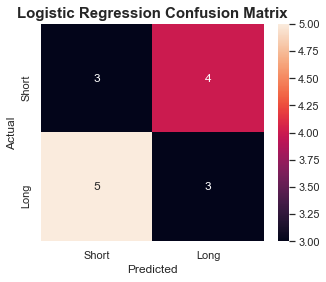

In [31]:
#plotting confusion matrix
cm = confusion_matrix(Y_test, Y_pred_1)
df = pd.DataFrame(cm, index=['Short', 'Long'], columns=['Short', 'Long'])
plt.figure(figsize=(5,4))
sns.heatmap(df,annot=True, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title( "Logistic Regression Confusion Matrix", fontsize=15, fontweight="bold")
plt.show()

In [32]:
#classification report
print(classification_report(Y_test, Y_pred_1))

              precision    recall  f1-score   support

          -1       0.38      0.43      0.40         7
           1       0.43      0.38      0.40         8

    accuracy                           0.40        15
   macro avg       0.40      0.40      0.40        15
weighted avg       0.40      0.40      0.40        15



# Gradient Boosting Classifier

In [33]:
# create model
model_2 = GradientBoostingClassifier(n_estimators=10, max_features='auto')

# train model
model_2.fit(X_train_scaled, Y_train)

# make some predictions
Y_pred_train_2 = model_2.predict(X_train_scaled)
Y_pred_2 = model_2.predict(X_test_scaled)

# accuracy
print("Gradient Boosting Classifier Model train accuracy:", accuracy_score(Y_train, Y_pred_train_2))
print("Gradient Boosting Classifier Model test accuracy:", accuracy_score(Y_test, Y_pred_2))

Gradient Boosting Classifier Model train accuracy: 0.9661016949152542
Gradient Boosting Classifier Model test accuracy: 0.5333333333333333


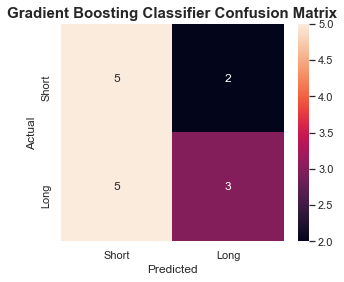

In [34]:
#plotting confusion matrix
cm = confusion_matrix(Y_test, Y_pred_2)
df = pd.DataFrame(cm, index=['Short', 'Long'], columns=['Short', 'Long'])
plt.figure(figsize=(5,4))
sns.heatmap(df,annot=True, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title( "Gradient Boosting Classifier Confusion Matrix", fontsize=15, fontweight="bold")
plt.show()


In [35]:
#classification report
print(classification_report(Y_test, Y_pred_2))

              precision    recall  f1-score   support

          -1       0.50      0.71      0.59         7
           1       0.60      0.38      0.46         8

    accuracy                           0.53        15
   macro avg       0.55      0.54      0.52        15
weighted avg       0.55      0.53      0.52        15

